# Exercise 1: t-SNE

## Do not start the exercise until you fully understand the submission guidelines.


* The homework assignments are executed automatically.
* Failure to comply with the following instructions will result in a significant penalty.
* Appeals regarding your failure to read these instructions will be denied.

## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/).
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains this notebook, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone. The name of the notebook should follow the same structure.
   
Please use only a **zip** file in your submission.

---
##❗❗❗❗❗❗❗❗❗**This is mandatory**❗❗❗❗❗❗❗❗❗
## Please write your RUNI emails in this cell:

### ***yonatan.greenshpan@post.runi.ac.il***
---

## Please sign that you have read and understood the instructions:

### ***204266191***  

---


In [1]:
# Import necessary libraries
import numpy as np
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

np.random.seed(42)

In [ ]:
# Import additional libraries
from datasets import load_dataset
from datasets import Dataset
from sentence_transformers import SentenceTransformer


# Design your algorithm
Make sure to describe the algorithm, its limitations, and describe use-cases.

## **Algorithm Description**

t-SNE is a nonlinear dimensionality-reduction algorithm designed to embed high-dimensional data into a low-dimensional space while preserving **local neighborhood structure**.

The core idea is to convert pairwise distances in high-dimensional space into probability distributions, and then find a low-dimensional embedding whose probability distribution is as similar as possible by minimizing KL-divergence. It is importent to note, that in t-SNE we tune the data’s low-dimensional coordinates themselves rather than adjusting model parameters.

The algorithm consists of the following stages:

### **1. Compute Pairwise Affinities in High Dimension**

For each point $x_i$, define conditional probabilities:

$$
p_{j|i} \propto \exp\left(-\frac{\|x_i - x_j\|^2}{2\sigma_i^2}\right)
$$

- $x_i$ — the $i$-th data point in the original high-dimensional space.  
- $x_j$ — a neighboring data point whose similarity to $x_i$ we measure.  
- $\|x_i - x_j\|^2$ — squared Euclidean distance between points $x_i$ and $x_j$.  
- $\sigma_i$ — the bandwidth (standard deviation) of the Gaussian centered at $x_i$, selected individually per point.  
- $p_{j|i}$ — the conditional probability that $x_i$ would pick $x_j$ as a neighbor.  

### **2. Symmetrize the Probabilities**

Because each point $x_i$ uses its own $\sigma_i$, the conditional probabilities $p_{j|i}$ and $p_{i|j}$ reflect two different local neighborhoods (“two different families of relatives”). So even if the distance $\|x_i - x_j\|$ is the same in both directions, the probabilities are not. t-SNE cannot work with two different notions of similarity for the same pair. To define **one shared, mutual similarity** between $x_i$ and $x_j$, we combine the two directional probabilities:  

$$
p_{ij} = \frac{p_{j|i} + p_{i|j}}{2n}
$$

### **3. Initialize Low-Dimensional Embeddings**

Randomly initialize $y_i \in \mathbb{R}^2$ (or $\mathbb{R}^3$) according to the visualization type we want.


### **4. Define Low-Dimensional Similarities Using a t-Distribution**

In the low-dimensional space, we also want a *imilarity distribution between points: pairs that are close in 2D should get high similarity, and far pairs should get low similarity.

If we used a **Gaussian** here (like in the high-dimensional space), many points would be pulled too close together in the center, which leads to the **crowding problem**: too many moderately distant points all collapse near the origin.

To avoid this, t-SNE uses a **heavy-tailed** distribution so that moderately far points still exert noticeable “repulsive” force.  We choose a **Student-t distribution with 1 degree of freedom** (also known as the Cauchy distribution), whose probability density function is:

$$
f(t) = \frac{\Gamma\!\left(\frac{\nu + 1}{2}\right)}
{\sqrt{\nu\pi}\,\Gamma\!\left(\frac{\nu}{2}\right)}
\left(1 + \frac{t^2}{\nu}\right)^{-\frac{\nu + 1}{2}}
$$

For $\nu = 1$ this simplifies to (up to a constant factor):

$$
f(t) \propto \frac{1}{1 + t^2}
$$

In t-SNE we plug in the low-dimensional distance
$t = \|y_i - y_j\|$ and then normalize over all pairs to get a proper probability distribution:

$$
q_{ij} = \frac{(1 + \|y_i - y_j\|^2)^{-1}}
{\sum_{k \neq l} (1 + \|y_k - y_l\|^2)^{-1}}
$$

This $q_{ij}$ is the **low-dimensional similarity** between $y_i$ and $y_j$.  


### **5. Minimize KL-Divergence Between $P$ and $Q$**

We optimize this expression iteratively using **plain gradient descent** (no early exaggeration and no momentum in the current implementation). The optimizer updates the low-dimensional coordinates directly at each step:

$$
\mathrm{KL}(P\|Q)
=
\sum_{i \neq j} p_{ij} \log \frac{p_{ij}}{q_{ij}}
$$

For a description of how new data points are embedded (the `transform()` extension), see the corresponding section.

## **Limitations**

- Does **not scale well** to very large datasets, naively complexity is $O(n^2)$)
- **Global structure is unreliable** — only local neighborhoods are meaningful.
- t-SNE optimizes the embedded coordinates themselves, no so we **don't get at the end of the learning a function that can map new data** into the space like in PCA
- **Sensitive to hyperparameters** such as perplexity and learning rate.  
- **No inverse transform** — cannot reconstruct high-dimensional vectors from the 2D embedding.

---

## **Use-Cases**

- **Visualization of high-dimensional datasets** such as images, text embeddings, biological data, user behavior features, or any complex structured data.
- **Exploratory Data Analysis (EDA)** to reveal clusters, subgroups, anomalies, or hidden structure that may not be visible in the raw high-dimensional space.
- **Understanding model representations**, for example examining the latent space of neural networks, autoencoders, or transformer embeddings.
---
## **Hyperparameters**

Our `CustomTSNE` class exposes four main hyperparameters:

- **`perplexity`**  
  Controls the effective number of neighbors each point tries to keep nearby in the embedding.  
  In the code it is used to choose the local bandwidths $\sigma_i$ via a binary search so that the entropy of $p_{j\mid i}$ matches the target perplexity (default: `30.0`).

- **`n_components`**  
  The dimensionality of the embedding space - we use `2`.  
  In our implementation this directly sets the size of each $y_i \in \mathbb{R}^{\text{n\_components}}$ (default: `2`).

- **`n_iter`**  
  Number of optimization steps in gradient descent.  
  A larger value allows the forces between points (attractive vs. repulsive) to stabilize, but increases runtime (default: `1000`).

- **`learning_rate`**  
  Step size used in the gradient updates of the low-dimensional coordinates $y_i$.  
  Too small → slow convergence; too large → unstable or noisy embeddings. Our default (`200.0`) is suitable for our small. In the extension that accepts additional data, for efficency we will make the learning rate much lower and do smart initiatlization



# Your implementations
You may add new cells, write helper functions or test code as you see fit.
Please use the cell below and include a description of your implementation.
Explain code design consideration, algorithmic choices and any other details you think is relevant to understanding your implementation.
Failing to explain your code will lead to point deductions.

### **Implementation Summary**

This implementation provides a from-scratch version of t-SNE, including both the standard `fit_transform()` procedure and a lightweight extension for embedding new samples using `transform()`. The code follows the classical structure of the algorithm: it computes high-dimensional conditional probabilities using per-point bandwidths obtained by binary search (driven by the chosen perplexity), symmetrizes them into a joint distribution `P`, initializes a low-dimensional embedding, and optimizes the KL-divergence between `P` and the Student-t based low-dimensional distribution `Q`.

The optimizer uses **plain gradient descent** with a fixed learning rate. No early exaggeration or momentum are enabled through the class interface; the default behavior is deliberately simple and transparent. This keeps the optimization easy to reason about and makes debugging straightforward.

For new-point embedding, the functions `transform()` and `_optimize_new_point_embedding()` are organized to keep the process clear and modular, not to redesign the algorithm. The same building blocks used in the main t-SNE pipeline—distance computations, conditional probability estimation, and Student-t affinities—are reused. The `transform()` method computes conditional probabilities from each new point to the original dataset, initializes the 2D position near a weighted average of neighbors, and refines this position via a smaller-step gradient descent while keeping the existing embedding fixed.

A key design decision throughout was to **split functionality into many small, focused methods**. Each step—pairwise distances, entropy computation, sigma binary search, symmetrization, low-dimensional affinity computation, gradient calculation—has its own function. This improves clarity, makes the code easier to follow, and significantly increases **testability**, since each component can be independently verified with unit tests (as demonstrated in the accompanying test cells). The result is an implementation that is faithful to the original algorithm while being explicit, readable, and well-structured for experimentation.


In [ ]:
class CustomTSNE:
    """A from-scratch implementation of t-SNE with basic transform support."""

    def __init__(self, perplexity=30.0, n_components=2, n_iter=1000, learning_rate=200.0):
        self.perplexity = perplexity
        self.n_components = n_components
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        self.sigmas_ = None
        self.X_fit_ = None
        self.Y_fit_ = None

    # ==========================================================================
    # PUBLIC METHODS
    # ==========================================================================

    def fit_transform(self, X):
        """Fit t-SNE model to X and return a low-dimensional embedding."""
        X = np.asarray(X, dtype=float)
        if X.ndim != 2:
            raise ValueError("X must be a 2D array")

        P, sigmas = self._compute_high_dim_affinities(X)
        Y_init = self._initialize_embedding(len(X), random_state=42)
        Y = self._optimize_embedding(P, Y_init)

        self.X_fit_ = X
        self.sigmas_ = sigmas
        self.Y_fit_ = Y
        return Y

    def transform(self, X_original, Y_original, X_new):
        """Map new samples into an existing t-SNE embedding."""
        X_original = np.asarray(X_original, dtype=float)
        Y_original = np.asarray(Y_original, dtype=float)
        X_new = np.asarray(X_new, dtype=float)

        if X_original.shape[0] != Y_original.shape[0]:
            raise ValueError("X_original and Y_original must contain the same number of samples")
        if X_original.shape[1] != X_new.shape[1]:
            raise ValueError("Original and new data must have the same number of features")

        P_new = self._compute_conditional_probs_new(X_original, X_new)
        # Y_new_init = np.random.normal(loc=0.0, scale=1e-4, size=(X_new.shape[0], self.n_components))

        # =========================================================================
        P_new = self._compute_conditional_probs_new(X_original, X_new)
        # initialize near neighbors in the existing map
        Y_new_init = P_new @ Y_original
        Y_new_init += np.random.normal(0.0, 1e-3, size=Y_new_init.shape)
        # ========================================================================+

        return self._optimize_new_point_embedding(Y_original, P_new, Y_new_init, lr=0.1)

    # ==========================================================================
    # PRIVATE METHODS
    # ==========================================================================

    def _compute_pairwise_distances(self, X):
        """Compute pairwise squared Euclidean distances between points in X."""
        X = np.asarray(X, dtype=float)
        sum_sq = np.sum(X ** 2, axis=1, keepdims=True)
        D = sum_sq + sum_sq.T - 2 * np.dot(X, X.T)
        np.maximum(D, 0, out=D)
        return D

    def _compute_entropy_and_conditional_probs(self, Di, sigma):
        """Return entropy and conditional probabilities for row Di with bandwidth sigma."""
        sigma = max(float(sigma), 1e-10)
        denom = 2.0 * sigma ** 2
        Pi = np.exp(-Di / denom)
        Pi[Di == 0] = 0.0  # exclude self
        sum_pi = np.sum(Pi)
        if sum_pi == 0:
            Pi = np.zeros_like(Di)
        else:
            Pi /= sum_pi
        Pi = np.clip(Pi, 1e-12, None)
        Pi /= np.sum(Pi)
        nz = Pi > 0
        H = -np.sum(Pi[nz] * np.log2(Pi[nz]))
        return H, Pi

    def _binary_search_sigma(self, Di, desired_perplexity, tol=1e-5, max_iter=50):
        """Binary search sigma so that perplexity matches the target."""
        target_entropy = np.log2(desired_perplexity)
        sigma_min, sigma_max = 1e-5, np.inf
        sigma = 1.0
        Pi = np.zeros_like(Di)

        for _ in range(max_iter):
            H, Pi = self._compute_entropy_and_conditional_probs(Di, sigma)
            diff = H - target_entropy
            if abs(diff) < tol:
                break
            if diff > 0:  # entropy too high ⇒ decrease sigma
                sigma_max = sigma
                sigma = (sigma + sigma_min) / 2 if np.isfinite(sigma_max) else sigma / 2
            else:  # entropy too low ⇒ increase sigma
                sigma_min = sigma
                sigma = (sigma + sigma_max) / 2 if np.isfinite(sigma_max) else sigma * 2
            sigma = max(sigma, 1e-5)

        return sigma, Pi

    def _compute_high_dim_affinities(self, X):
        """Compute symmetric affinity matrix P and per-point sigmas."""
        X = np.asarray(X, dtype=float)
        n_samples = X.shape[0]
        D = self._compute_pairwise_distances(X)
        P_cond = np.zeros_like(D)
        sigmas = np.zeros(n_samples)

        for i in range(n_samples):
            sigma, Pi = self._binary_search_sigma(D[i], self.perplexity)
            sigmas[i] = sigma
            P_cond[i] = Pi

        P = self._symmetrize_probabilities(P_cond)
        return P, sigmas

    def _symmetrize_probabilities(self, P_cond):
        """Symmetrize conditional probabilities into joint distribution."""
        n = P_cond.shape[0]
        P = (P_cond + P_cond.T) / (2.0 * n)
        np.fill_diagonal(P, 0.0)
        P = np.maximum(P, 1e-12)
        P /= np.sum(P)
        return P

    def _compute_low_dim_affinities(self, Y):
        """Compute Student-t based low-dimensional affinities."""
        D = self._compute_pairwise_distances(Y)
        inv = 1.0 / (1.0 + D)
        np.fill_diagonal(inv, 0.0)
        Q = inv / np.sum(inv)
        Q = np.maximum(Q, 1e-12)
        Q /= np.sum(Q)
        return Q

    def _compute_kl_divergence(self, P, Q):
        """Return KL(P‖Q)."""
        mask = P > 0
        return np.sum(P[mask] * (np.log(P[mask]) - np.log(Q[mask])))

    def _compute_gradient(self, P, Q, Y):
        """Compute gradient of KL divergence with respect to Y."""
        distances = self._compute_pairwise_distances(Y)
        inv = 1.0 / (1.0 + distances)
        np.fill_diagonal(inv, 0.0)
        coeff = 4.0 * ((P - Q) * inv)
        grad = np.zeros_like(Y)
        for i in range(Y.shape[0]):
            diff = Y[i] - Y
            grad[i] = np.sum(coeff[i][:, None] * diff, axis=0)
        return grad

    def _initialize_embedding(self, n_samples, random_state=None):
        """Randomly initialize the embedding."""
        rng = np.random.RandomState(random_state)
        return rng.normal(loc=0.0, scale=1e-4, size=(n_samples, self.n_components))

    def _optimize_embedding(self, P, Y_init, early_exaggeration=4.0, momentum=0.5):
        """Optimize embedding via gradient descent with momentum."""
        Y = Y_init.copy()
        velocity = np.zeros_like(Y)
        switch_iter = min(250, self.n_iter // 2)

        for it in range(self.n_iter):
            P_use = P * early_exaggeration if it < switch_iter else P
            Q = self._compute_low_dim_affinities(Y)
            grad = self._compute_gradient(P_use, Q, Y)
            if it == switch_iter:
                momentum = 0.8
            velocity = momentum * velocity - self.learning_rate * grad
            Y += velocity
            Y -= np.mean(Y, axis=0, keepdims=True)
        return Y

    def _compute_distances_to_original(self, X_original, X_new):
        """Compute squared distances from new to original points."""
        X_original = np.asarray(X_original, dtype=float)
        X_new = np.asarray(X_new, dtype=float)
        sum_new = np.sum(X_new ** 2, axis=1, keepdims=True)
        sum_orig = np.sum(X_original ** 2, axis=1)
        D = sum_new + sum_orig - 2 * np.dot(X_new, X_original.T)
        return np.maximum(D, 0)

    def _compute_conditional_probs_new(self, X_original, X_new, sigmas_original=None):
        """Compute conditional probabilities from new points to original ones."""
        D_new = self._compute_distances_to_original(X_original, X_new)
        P_new = np.zeros_like(D_new)
        for i in range(D_new.shape[0]):
            _, Pi = self._binary_search_sigma(D_new[i], self.perplexity)
            P_new[i] = Pi
        return P_new

    # def _optimize_new_point_embedding(self, Y_original, P_new, Y_new_init, n_iter=None):
    #     """Optimize embeddings for new points while keeping originals fixed."""
    #     Y_original = np.asarray(Y_original, dtype=float)
    #     Y_new = Y_new_init.copy()
    #     if n_iter is None:
    #         n_iter = 75

    #     for _ in range(n_iter):
    #         for idx in range(Y_new.shape[0]):
    #             diff = Y_new[idx] - Y_original
    #             dist_sq = np.sum(diff ** 2, axis=1)
    #             inv = 1.0 / (1.0 + dist_sq)
    #             Q = inv / np.sum(inv)
    #             coeff = 4.0 * (P_new[idx] - Q) * inv
    #             grad = np.sum(coeff[:, None] * diff, axis=0)
    #             # Y_new[idx] -= self.learning_rate * grad

    #             Y_new[idx] -= self.learning_rate * grad

    #         # Y_new -= np.mean(Y_new, axis=0, keepdims=True)
    #     return Y_new
    def _optimize_new_point_embedding(self, Y_original, P_new, Y_new_init, n_iter=None, lr=0.1):
        Y_original = np.asarray(Y_original, dtype=float)
        Y_new = Y_new_init.copy()
        if n_iter is None:
            n_iter = 100 # Increased slightly as vectorization is fast

        # Pre-compute constants if possible to save time
        # But standard t-SNE requires re-computing Q every step
        
        for _ in range(n_iter):
            # Vectorized distance calculation
            # Shape: (N_new, N_original, 2)
            # Expand dims to broadcast: (N_new, 1, 2) - (1, N_original, 2)
            diff = Y_new[:, np.newaxis, :] - Y_original[np.newaxis, :, :]
            
            # Squared Euclidean distance: sum over the coordinate axis (axis 2)
            # Shape: (N_new, N_original)
            dist_sq = np.sum(diff ** 2, axis=2)
            
            # Student t-distribution (Q numerator equivalent)
            # Shape: (N_new, N_original)
            inv = 1.0 / (1.0 + dist_sq)
            
            # Normalize Q per row (per new point)
            # Q shape: (N_new, N_original)
            Q = inv / np.sum(inv, axis=1, keepdims=True)
            
            # Gradient Force
            # (P - Q) * inv term: Shape (N_new, N_original)
            force = 4.0 * (P_new - Q) * inv
            
            # Apply force to vectors
            # We need to multiply force (N_new, N_orig) by diff (N_new, N_orig, 2)
            # Expand force to (N_new, N_orig, 1)
            grads = np.sum(force[:, :, np.newaxis] * diff, axis=1)
            
            # Update all points at once
            Y_new -= lr * grads  # Use the local small learning rate
            
        return Y_new


## tests


First we will test all of our private methods:
1. **_compute_pairwise_distances**
2. **_compute_entropy_and_conditional_probs**
3. **_binary_search_sigma**
4. **_compute_high_dim_affinities**
5. **_symmetrize_probabilities**
6. **_compute_low_dim_affinities**
7. **_compute_kl_divergence**
8. **_compute_gradient**
9. **_initialize_embedding**
10. **_optimize_embedding**
11. **_compute_distances_to_original**
12. **_compute_conditional_probs_new**
13. **_optimize_new_point_embedding**

In [ ]:
# ============================================================
# 1. _compute_pairwise_distances
# ============================================================
def test_compute_pairwise_distances_basic():
    cases = [
        (np.array([[0.0], [1.0]]), "1D two points distance 1"),
        (np.array([[0.0, 0.0], [3.0, 4.0]]), "2D (0,0) and (3,4) distance 5^2=25"),
        (np.array([[1.0, 2.0], [1.0, 2.0]]), "identical points distance 0"),
    ]
    tsne = CustomTSNE()
    for X, desc in cases:
        D = tsne._compute_pairwise_distances(X)
        n = X.shape[0]
        assert D.shape == (n, n), f"[{desc}] shape {D.shape} != {(n, n)}"
        assert np.all(D >= -1e-12), f"[{desc}] negative distances, min={D.min()}"
        assert np.allclose(np.diag(D), 0.0), f"[{desc}] diagonal not zero: {np.diag(D)}"
        assert np.allclose(D, D.T), f"[{desc}] matrix is not symmetric"


# ============================================================
# 2. _compute_entropy_and_conditional_probs
# ============================================================
def test_compute_entropy_and_conditional_probs_properties():
    cases = [
        (np.array([0.0, 1.0, 4.0]), 1.0, "simple distances, moderate sigma"),
        (np.array([0.0, 10.0, 20.0]), 0.1, "very small sigma, sharp distribution"),
        (np.array([0.0, 1.0, 1.0]), 5.0, "large sigma, more uniform"),
    ]
    tsne = CustomTSNE()
    for Di, sigma, desc in cases:
        H, P = tsne._compute_entropy_and_conditional_probs(Di, sigma)
        assert P.shape == Di.shape, f"[{desc}] P shape {P.shape} != Di shape {Di.shape}"
        assert np.isfinite(H), f"[{desc}] entropy not finite: {H}"
        assert np.all(P >= 0), f"[{desc}] negative prob, min={P.min()}"
        assert np.isclose(P.sum(), 1.0, atol=1e-6), f"[{desc}] P.sum={P.sum()}"
        assert P[0] <= 1e-10, f"[{desc}] self prob (Di==0) must be 0, got {P[0]}"


# ============================================================
# 3. _binary_search_sigma
# ============================================================
def test_binary_search_sigma_matches_perplexity():
    cases = [
        (np.array([0.0, 1.0, 4.0, 9.0]), 2.0, "target perplexity 2"),
        (np.array([0.0, 0.5, 2.0, 8.0, 15.0]), 4.0, "target perplexity 4"),
        (np.array([0.0, 3.0, 6.0, 9.0, 12.0, 15.0, 20.0]), 6.0, "target perplexity 6"),
    ]
    tsne = CustomTSNE()
    for Di, desired_perplexity, desc in cases:
        sigma, Pi = tsne._binary_search_sigma(Di, desired_perplexity)
        nz = Pi > 0
        H = -np.sum(Pi[nz] * np.log2(Pi[nz]))
        perp = 2 ** H
        assert sigma > 0, f"[{desc}] sigma <= 0: {sigma}"
        assert np.isclose(perp, desired_perplexity, rtol=1e-2), \
            f"[{desc}] perp={perp}, expected {desired_perplexity}"


# ============================================================
# 4. _symmetrize_probabilities
# ============================================================
def test_symmetrize_probabilities_small_example():
    tsne = CustomTSNE()
    P_cond = np.array(
        [
            [0.0, 0.7, 0.3],
            [0.6, 0.0, 0.4],
            [0.2, 0.8, 0.0],
        ]
    )
    P = tsne._symmetrize_probabilities(P_cond)
    assert P.shape == P_cond.shape, "P shape mismatch"
    assert np.all(P >= 0), f"P has negative entries, min={P.min()}"
    assert np.allclose(P, P.T), "P not symmetric"
    assert np.isclose(P.sum(), 1.0, atol=1e-6), f"P.sum={P.sum()}"
    assert np.allclose(np.diag(P), 0.0), "diag(P) not zero"


# ============================================================
# 5. _compute_high_dim_affinities
# ============================================================
def test_compute_high_dim_affinities_properties():
    cases = [
        (3, 2, "3 points in 2D"),
        (5, 3, "5 points in 3D"),
        (10, 4, "10 points in 4D"),
    ]
    for n_samples, n_features, desc in cases:
        rng = np.random.RandomState(0)
        X = rng.normal(size=(n_samples, n_features))
        tsne = CustomTSNE(perplexity=3.0)
        P, sigmas = tsne._compute_high_dim_affinities(X)

        assert P.shape == (n_samples, n_samples), f"[{desc}] P shape={P.shape}"
        assert sigmas.shape == (n_samples,), f"[{desc}] sigmas shape={sigmas.shape}"
        assert np.all(sigmas > 0), f"[{desc}] non-positive sigma: {sigmas}"
        assert np.isclose(P.sum(), 1.0, atol=1e-6), f"[{desc}] P.sum={P.sum()}"
        assert np.allclose(P, P.T), f"[{desc}] P not symmetric"


# ============================================================
# 6. _compute_low_dim_affinities
# ============================================================
def test_compute_low_dim_affinities_properties():
    rng = np.random.RandomState(1)
    cases = [
        (np.array([[0.0, 0.0], [1.0, 0.0]]), "two points in 2D"),
        (np.array([[0.0], [1.0], [2.0]]), "three points in 1D"),
        (rng.normal(size=(4, 3)), "four points in 3D"),
    ]
    tsne = CustomTSNE()
    for Y, desc in cases:
        Q = tsne._compute_low_dim_affinities(Y)
        n = Y.shape[0]
        assert Q.shape == (n, n), f"[{desc}] Q shape={Q.shape}"
        assert np.all(Q >= 0), f"[{desc}] Q has negative entries, min={Q.min()}"
        assert np.isclose(Q.sum(), 1.0, atol=1e-6), f"[{desc}] Q.sum={Q.sum()}"
        assert np.allclose(np.diag(Q), 0.0), f"[{desc}] diag(Q) not zero"


# ============================================================
# 7. _compute_kl_divergence
# ============================================================
def test_compute_kl_divergence_zero_and_positive():
    tsne = CustomTSNE()
    P = np.array([[0.0, 0.5, 0.5],
                  [0.5, 0.0, 0.5],
                  [0.5, 0.5, 0.0]])
    P = P / P.sum()

    kl_same = tsne._compute_kl_divergence(P, P)
    assert np.isclose(kl_same, 0.0, atol=1e-10), f"KL(P||P)={kl_same} != 0"

    Q = P.copy()
    Q[0, 1] += 0.1
    Q[0, 2] -= 0.1
    Q = np.maximum(Q, 1e-12)
    Q /= Q.sum()
    kl_diff = tsne._compute_kl_divergence(P, Q)
    assert kl_diff > 0, f"KL(P||Q) should be >0, got {kl_diff}"


# ============================================================
# 8. _compute_gradient
# ============================================================
def test_compute_gradient_shape_and_finiteness():
    rng = np.random.RandomState(0)
    X = rng.normal(size=(5, 2))
    tsne = CustomTSNE(perplexity=3.0, n_components=2, n_iter=250)

    P, _ = tsne._compute_high_dim_affinities(X)
    Y_init = tsne._initialize_embedding(len(X), random_state=0)
    Q = tsne._compute_low_dim_affinities(Y_init)
    grad = tsne._compute_gradient(P, Q, Y_init)

    assert grad.shape == Y_init.shape, f"grad shape {grad.shape}, expected {Y_init.shape}"
    assert np.all(np.isfinite(grad)), "grad has NaN or inf"


# ============================================================
# 9. _initialize_embedding
# ============================================================
def test_initialize_embedding_stats():
    cases = [(3, 2), (10, 2), (5, 3)]
    for n_samples, n_components in cases:
        tsne = CustomTSNE(n_components=n_components)
        Y = tsne._initialize_embedding(n_samples, random_state=123)
        assert Y.shape == (n_samples, n_components), "shape mismatch"
        mean = np.mean(Y)
        std = np.std(Y)
        assert abs(mean) < 1e-3, f"mean={mean} not near 0"
        assert 1e-5 < std < 1e-3, f"std={std} not around 1e-4"


# ============================================================
# 10. _optimize_embedding
# ============================================================
def test_optimize_embedding_non_worsening_kl():
    rng = np.random.RandomState(0)
    X = rng.normal(size=(8, 3))
    tsne = CustomTSNE(perplexity=3.0, n_components=2, n_iter=100, learning_rate=100.0)

    P, _ = tsne._compute_high_dim_affinities(X)
    Y_init = tsne._initialize_embedding(len(X), random_state=0)
    Q_init = tsne._compute_low_dim_affinities(Y_init)
    kl_before = tsne._compute_kl_divergence(P, Q_init)

    Y_opt = tsne._optimize_embedding(P, Y_init)
    Q_opt = tsne._compute_low_dim_affinities(Y_opt)
    kl_after = tsne._compute_kl_divergence(P, Q_opt)

    assert kl_after <= kl_before * 1.2, \
        f"KL increased too much: before={kl_before}, after={kl_after}"


# ============================================================
# 11. _compute_distances_to_original + _compute_conditional_probs_new
# ============================================================
def test_compute_distances_and_conditional_probs_new():
    X_original = np.array([[0.0, 0.0], [1.0, 0.0], [0.0, 1.0]])
    X_new = np.array([[0.5, 0.0], [0.0, 0.5]])

    tsne = CustomTSNE(perplexity=2.0)
    D_new = tsne._compute_distances_to_original(X_original, X_new)

    d0 = (0.5 - 0.0) ** 2 + (0.0 - 0.0) ** 2
    d1 = (0.5 - 1.0) ** 2 + (0.0 - 0.0) ** 2
    d2 = (0.5 - 0.0) ** 2 + (0.0 - 1.0) ** 2

    assert np.isclose(D_new[0, 0], d0), "distance[0,0] mismatch"
    assert np.isclose(D_new[0, 1], d1), "distance[0,1] mismatch"
    assert np.isclose(D_new[0, 2], d2), "distance[0,2] mismatch"

    P_new = tsne._compute_conditional_probs_new(X_original, X_new)
    assert P_new.shape == D_new.shape, "P_new shape mismatch"
    row_sums = P_new.sum(axis=1)
    assert np.allclose(row_sums, 1.0, atol=1e-6), f"P_new rows sum={row_sums}"
    assert np.all(P_new >= 0), f"P_new has negative entries, min={P_new.min()}"


# ============================================================
# 12. _optimize_new_point_embedding
# ============================================================
def test_optimize_new_point_embedding_converges_reasonably():
    rng = np.random.RandomState(0)
    X_orig = rng.normal(size=(10, 3))
    tsne = CustomTSNE(perplexity=3.0, n_components=2, n_iter=200, learning_rate=50.0)

    P_orig, _ = tsne._compute_high_dim_affinities(X_orig)
    Y_init = tsne._initialize_embedding(len(X_orig), random_state=0)
    Y_orig = tsne._optimize_embedding(P_orig, Y_init)

    X_new = np.mean(X_orig, axis=0, keepdims=True) + rng.normal(scale=0.1, size=(3, 3))
    P_new = tsne._compute_conditional_probs_new(X_orig, X_new)
    Y_new_init = rng.normal(scale=1e-4, size=(3, tsne.n_components))
    Y_new = tsne._optimize_new_point_embedding(Y_orig, P_new, Y_new_init, n_iter=100)

    assert Y_new.shape == (3, tsne.n_components), "Y_new shape mismatch"
    assert np.all(np.isfinite(Y_new)), "Y_new has NaN or inf"
    orig_scale = np.std(Y_orig)
    new_scale = np.std(Y_new)
    assert new_scale < 10 * orig_scale, \
        f"new variance {new_scale} too large vs {orig_scale}"


# ============================================================
# Simple mini-runner for the notebook
# ============================================================
def run_all_custom_tsne_tests():
    tests = [
        ("pairwise distances", test_compute_pairwise_distances_basic),
        ("entropy & conditional probs", test_compute_entropy_and_conditional_probs_properties),
        ("binary search sigma", test_binary_search_sigma_matches_perplexity),
        ("symmetrize probabilities", test_symmetrize_probabilities_small_example),
        ("high-dim affinities", test_compute_high_dim_affinities_properties),
        ("low-dim affinities", test_compute_low_dim_affinities_properties),
        ("KL divergence", test_compute_kl_divergence_zero_and_positive),
        ("gradient", test_compute_gradient_shape_and_finiteness),
        ("initialize embedding", test_initialize_embedding_stats),
        ("optimize embedding", test_optimize_embedding_non_worsening_kl),
        ("distances + P_new", test_compute_distances_and_conditional_probs_new),
        ("optimize new points", test_optimize_new_point_embedding_converges_reasonably),
    ]

    n_pass, n_fail = 0, 0
    for name, func in tests:
        try:
            func()
            print(f"✅ {name}")
            n_pass += 1
        except AssertionError as e:
            print(f"❌ {name} — ASSERTION FAILED: {e}")
            n_fail += 1
        except Exception as e:
            print(f"💥 {name} — ERROR: {type(e).__name__}: {e}")
            n_fail += 1

    print("\n====== SUMMARY ======")
    print(f"Passed: {n_pass}")
    print(f"Failed: {n_fail}")
    print("=====================")


# actually run them now
run_all_custom_tsne_tests()


✅ pairwise distances
✅ entropy & conditional probs
✅ binary search sigma
✅ symmetrize probabilities
✅ high-dim affinities
✅ low-dim affinities
✅ KL divergence
✅ gradient
✅ initialize embedding
✅ optimize embedding
✅ distances + P_new
✅ optimize new points

====== SUMMARY ======
Passed: 12
Failed: 0


Now we will test the main `fit_transform()` method

In [ ]:
# ============================================================
# 13. fit_transform – basic properties & state
# ============================================================
def test_fit_transform_basic_properties():
    rng = np.random.RandomState(0)
    n_samples, n_features, n_components = 20, 5, 2
    X = rng.normal(size=(n_samples, n_features))

    tsne = CustomTSNE(perplexity=5.0, n_components=n_components, n_iter=250, learning_rate=100.0)
    Y = tsne.fit_transform(X)

    # 1) Output shape and finiteness
    assert Y.shape == (n_samples, n_components), f"Y shape {Y.shape}, expected {(n_samples, n_components)}"
    assert np.all(np.isfinite(Y)), "Y has NaN or inf"

    # 2) Internal state attributes
    assert tsne.X_fit_ is not None, "X_fit_ not set"
    assert tsne.sigmas_ is not None, "sigmas_ not set"
    assert tsne.Y_fit_ is not None, "Y_fit_ not set"

    assert tsne.X_fit_.shape == X.shape, f"X_fit_.shape {tsne.X_fit_.shape}, expected {X.shape}"
    assert tsne.sigmas_.shape == (n_samples,), f"sigmas_.shape {tsne.sigmas_.shape}, expected {(n_samples,)}"
    assert tsne.Y_fit_.shape == Y.shape, f"Y_fit_.shape {tsne.Y_fit_.shape}, expected {Y.shape}"

    # 3) sigmas positive
    assert np.all(tsne.sigmas_ > 0), f"non-positive sigmas: {tsne.sigmas_}"

    # 4) stored embedding matches returned embedding
    assert np.allclose(tsne.Y_fit_, Y), "Y_fit_ and returned Y differ"

    # 5) embedding roughly centered
    mean = Y.mean(axis=0)
    assert np.allclose(mean, 0.0, atol=1e-5), f"embedding not centered, mean={mean}"


# ============================================================
# 14. fit_transform – input validation
# ============================================================
def test_fit_transform_raises_on_invalid_input():
    tsne = CustomTSNE()

    # 1D array -> must raise
    X_1d = np.array([1.0, 2.0, 3.0])
    try:
        tsne.fit_transform(X_1d)
        assert False, "Expected ValueError for 1D input, but none was raised"
    except ValueError:
        pass

    # 3D array -> must raise
    X_3d = np.zeros((2, 2, 2))
    try:
        tsne.fit_transform(X_3d)
        assert False, "Expected ValueError for 3D input, but none was raised"
    except ValueError:
        pass


# ============================================================
# 15. fit_transform – determinism for same data & params
# ============================================================
def test_fit_transform_deterministic():
    rng = np.random.RandomState(123)
    X = rng.normal(size=(15, 4))

    tsne1 = CustomTSNE(perplexity=5.0, n_components=2, n_iter=200, learning_rate=100.0)
    tsne2 = CustomTSNE(perplexity=5.0, n_components=2, n_iter=200, learning_rate=100.0)

    Y1 = tsne1.fit_transform(X)
    Y2 = tsne2.fit_transform(X)

    # Because initialization uses fixed random_state=42, results should match
    assert np.allclose(Y1, Y2), "fit_transform is not deterministic for same data and params"


# ============================================================
# Simple mini-runner for the notebook (add to existing list)
# ============================================================
def run_all_custom_tsne_tests():
    tests = [
        ("fit_transform basic", test_fit_transform_basic_properties),
        ("fit_transform invalid input", test_fit_transform_raises_on_invalid_input),
        ("fit_transform determinism", test_fit_transform_deterministic),
    ]

    n_pass, n_fail = 0, 0
    for name, func in tests:
        try:
            func()
            print(f"✅ {name}")
            n_pass += 1
        except AssertionError as e:
            print(f"❌ {name} — ASSERTION FAILED: {e}")
            n_fail += 1
        except Exception as e:
            print(f"💥 {name} — ERROR: {type(e).__name__}: {e}")
            n_fail += 1

    print("\n====== SUMMARY ======")
    print(f"Passed: {n_pass}")
    print(f"Failed: {n_fail}")
    print("=====================")


# actually run them now
run_all_custom_tsne_tests()


✅ fit_transform basic
✅ fit_transform invalid input
✅ fit_transform determinism

====== SUMMARY ======
Passed: 3
Failed: 0


# Load data
Please use the cell below to discuss your dataset choice and why it is appropriate (or not) for this algorithm.

I use the AG News dataset (4 news topics) because it is a **good match for t-SNE** and more interesting than the MNIST as it is more NLP and not CV. The data both  naturally lives in a **high-dimensional embedding space** (384-dimensional BERT vectors), and the labels form **coherent semantic groups**, and we only need to visualize **local neighborhood structure**, which is exactly what t-SNE preserves well. The dataset is also small enough (after sub-sampling) to fit t-SNE’s $(O(n^2)$ complexity.

The raw dataset is ordered by class, so naïve sampling would give mostly one or two topics. To avoid this, I created `make_balanced_agnews_splits`, which selects approximately equal samples per class and then stratifies the train/test split. This ensures that—even with only 400 samples—we still capture all topic types and can expect meaningful clusters.

For preprocessing, I encode each text using BERT based model:
```python
model = SentenceTransformer("all-MiniLM-L6-v2")
emb = model.encode(text, normalize_embeddings=True)


In [ ]:
# 1. Load official dataset (AG News)
def make_balanced_agnews_splits(raw_ds, n_total=1000, test_size=0.25):
    """
    Return approx balanced train/test splits.
    - n_total total samples (approx balanced across classes)
    - test_size fraction for test split
    """

    texts = np.array(raw_ds["text"])
    labels = np.array(raw_ds["label"])

    classes = np.unique(labels)
    n_classes = len(classes)

    # approx-balanced count per class
    n_per_class = n_total // n_classes

    selected_idx = []

    for c in classes:
        idx_c = np.where(labels == c)[0]

        # choose as many as possible (no strict balance)
        if len(idx_c) <= n_per_class:
            chosen_c = idx_c
        else:
            # use global RNG seed
            chosen_c = np.random.choice(idx_c, size=n_per_class, replace=False)

        selected_idx.append(chosen_c)

    selected_idx = np.concatenate(selected_idx)

    # shuffle using global RNG
    np.random.shuffle(selected_idx)

    texts_balanced  = texts[selected_idx]
    labels_balanced = labels[selected_idx]

    # stratified split preserves the approx balance
    X_train, X_test, y_train, y_test = train_test_split(
        texts_balanced,
        labels_balanced,
        test_size=test_size,
        stratify=labels_balanced,
        random_state=None   # uses global RNG; deterministic due to global seed
    )

    ds_train = Dataset.from_dict({"text": list(X_train), "label": list(y_train)})
    ds_test  = Dataset.from_dict({"text": list(X_test),  "label": list(y_test)})

    return ds_train, ds_test

raw_ds = load_dataset("ag_news", split="train")

ds_train, ds_test = make_balanced_agnews_splits(
    raw_ds,
    n_total=400,
    test_size=0.25
)

text = ds_train["text"]
labels = ds_train["label"]

# 2. BERT embeddings (tiny, fast model)
model = SentenceTransformer("all-MiniLM-L6-v2")
emb = model.encode(text, normalize_embeddings=True)




# t-SNE demonstration
Demonstrate your t-SNE implementation.

Add plots and figures. The code below is just to help you get started, and should not be your final submission.

Please use the cell below to describe your results and tests.

Describe the difference between your implementation and the sklearn implementation. Hint: you can look at the documentation.

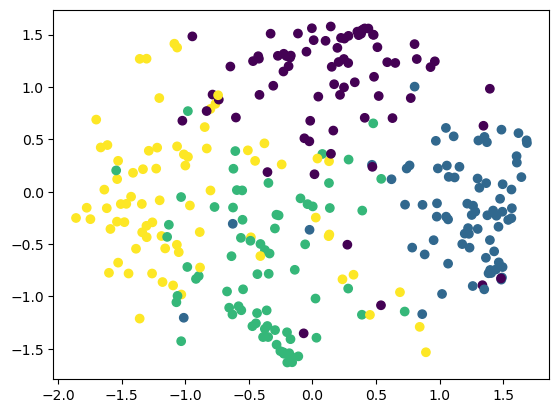

In [ ]:
# # 3. t-SNE
my_tsne = CustomTSNE(n_components=2,perplexity=30)
XY = my_tsne.fit_transform(emb)


# # 4. Quick scatter
plt.scatter(XY[:,0], XY[:,1], c=labels)
plt.show()


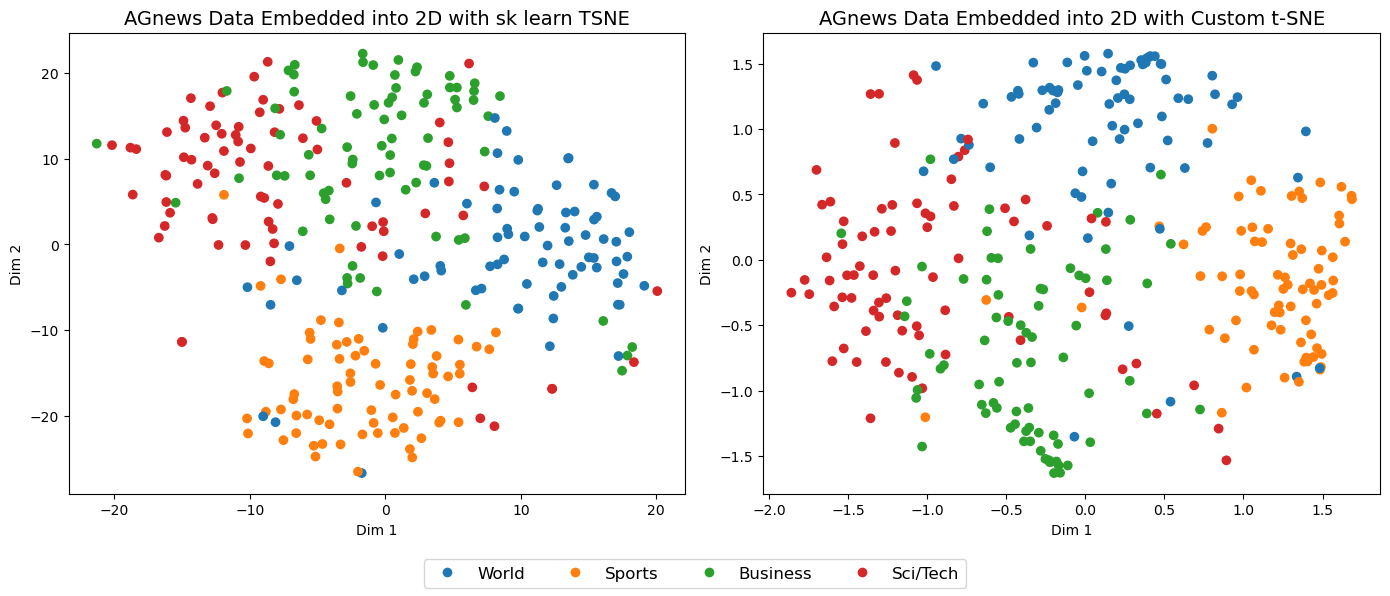

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# AG News class names
AG_NEWS_CLASSES = ["World", "Sports", "Business", "Sci/Tech"]

# Explicit color map (guaranteed consistent)
COLOR_MAP = {
    0: "#1f77b4",  # blue
    1: "#ff7f0e",  # orange
    2: "#2ca02c",  # green
    3: "#d62728",  # red
}

# Convert labels to colors
point_colors = [COLOR_MAP[int(l)] for l in labels]

# 1. sklearn TSNE
sk_tsne = TSNE(
    n_components=2,
    perplexity=30,
    random_state=42
)
XY_sklearn = sk_tsne.fit_transform(emb)

# 2. your implementation
my_tsne = CustomTSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1000
)
XY_custom = my_tsne.fit_transform(emb)

# 3. side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- sklearn ---
axes[0].scatter(
    XY_sklearn[:, 0], XY_sklearn[:, 1],
    c=point_colors
)
axes[0].set_title("AGnews Data Embedded into 2D with sk learn TSNE", fontsize=14)
axes[0].set_xlabel("Dim 1")
axes[0].set_ylabel("Dim 2")

# --- custom ---
axes[1].scatter(
    XY_custom[:, 0], XY_custom[:, 1],
    c=point_colors
)
axes[1].set_title("AGnews Data Embedded into 2D with Custom t-SNE", fontsize=14)
axes[1].set_xlabel("Dim 1")
axes[1].set_ylabel("Dim 2")

# --- Legend ---
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=COLOR_MAP[i], markersize=8)
    for i in range(4)
]

fig.legend(
    legend_handles,
    AG_NEWS_CLASSES,
    loc="lower center",
    ncol=4,
    fontsize=12
)

plt.tight_layout(rect=[0, 0.07, 1, 1])
plt.show()


Both implementations work and produce **visually clear separation** between the four AG News topics: in both plots, the Sports (orange) cluster is very distinct, while World, Business and Sci/Tech form overlapping but still recognizable groups. This shows that my from-scratch t-SNE correctly captures the local neighborhood structure of the BERT embeddings.

In terms of computation, my implementation uses the **naïve $O(n^2)$ t-SNE**: all pairwise distances and all forces are computed explicitly in NumPy, with a Python loop over points in each gradient step. In contrast, `sklearn.manifold.TSNE` uses the **Barnes–Hut approximation** by default (`method="barnes_hut"`), which reduces the dominant part of the algorithm from $O(n^2)$ to roughly $O(n \log n)$ and is implemented in optimized C/Cython, so it runs faster and scales better to larger $n$.

There are also differences in the **optimization details**. In my version I used a fixed learning rate and did *not* use early exaggeration or momentum, so the optimization is plain gradient descent on the KL objective. Scikit-learn’s implementation, on the other hand, includes a dedicated early-exaggeration phase controlled by the `early_exaggeration` parameter (default $12.0$) and uses a more elaborate learning-rate schedule (`learning_rate="auto"` by default). 

Finally, the **numerical scale** of the two embeddings is different (roughly $[-20, 20]$ for scikit-learn vs. about $[-2, 2]$ for my code). This is expected: t-SNE is invariant to global translation, rotation and scaling of the embedding, and different learning-rate / gradient conventions (scikit-learn even notes that its effective learning rate is scaled by a factor of 4 compared to other implementations) naturally lead to different coordinate ranges. The important point is that the relative arrangement and clustering of points are qualitatively similar, not the absolute numbers on the axes.


# t-SNE extension - mapping new samples
Demonstrate your t-SNE transformation procedure.

Add plots and figures.

Please use the cell below t describe your suggested approach in detail. Use formal notations where appropriate.
Describe and discuss your results.

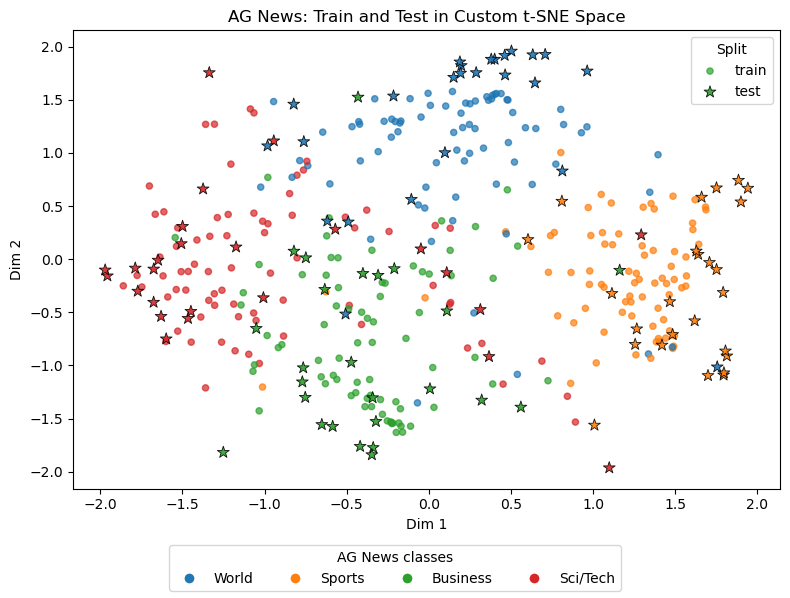

In [ ]:
# ============================
# 1. Prepare train / test data
# ============================
# These come from the previous cells:
# - emb       : train embeddings
# - emb_test  : test embeddings
# - XY_custom : train embedding from my_tsne.fit_transform(emb)
# - custom_Y_new : test embedding from my_tsne.transform(...)

X_train = emb
X_test  = emb_test

Y_train_ext = XY_custom      # extension map: train
Y_test_ext  = custom_Y_new   # extension map: new points

n_train = X_train.shape[0]
n_test  = X_test.shape[0]

print(f"#train = {n_train}, #test(new) = {n_test}")

# ==========================================
# 2. Reference embedding: train + test t-SNE
#    (fresh t-SNE run on ALL points)
# ==========================================
X_all = np.vstack([X_train, X_test])

tsne_ref = CustomTSNE(
    n_components=2,
    perplexity=30.0,
    n_iter=1000,
    learning_rate=200.0,
)
Y_all_ref = tsne_ref.fit_transform(X_all)

Y_train_ref = Y_all_ref[:n_train]
Y_test_ref  = Y_all_ref[n_train:]

# ==========================================
# 3. Neighbor-consistency metric (Jaccard)
# ==========================================
def neighbor_consistency(Y_train_ref, Y_test_ref, Y_train_ext, Y_test_ext, k=10):
    """Average Jaccard overlap between k-NN of new points under reference vs extension maps."""
    n_new = Y_test_ref.shape[0]
    scores = []

    for i in range(n_new):
        # k-NN among TRAIN points in the reference map
        diff_ref = Y_train_ref - Y_test_ref[i]
        dist_ref = np.sum(diff_ref**2, axis=1)
        nn_ref = np.argsort(dist_ref)[:k]

        # k-NN among TRAIN points in the extension map
        diff_ext = Y_train_ext - Y_test_ext[i]
        dist_ext = np.sum(diff_ext**2, axis=1)
        nn_ext = np.argsort(dist_ext)[:k]

        set_ref = set(nn_ref.tolist())
        set_ext = set(nn_ext.tolist())
        inter = len(set_ref & set_ext)
        union = len(set_ref | set_ext)
        jaccard = inter / union if union > 0 else 0.0
        scores.append(jaccard)

    scores = np.array(scores)
    summary = {
        "k": k,
        "mean": float(scores.mean()),
        "std": float(scores.std()),
        "min": float(scores.min()),
        "25%": float(np.percentile(scores, 25)),
        "50% (median)": float(np.percentile(scores, 50)),
        "75%": float(np.percentile(scores, 75)),
        "max": float(scores.max()),
    }
    return summary

metrics = neighbor_consistency(
    Y_train_ref, Y_test_ref,
    Y_train_ext, Y_test_ext,
    k=10
)

# ============================
# 4. Pretty print the results
# ============================
print("\nNeighbor Consistency for transform() (k = {k})".format(k=metrics["k"]))
print("  mean   = {:.3f}".format(metrics["mean"]))
print("  std    = {:.3f}".format(metrics["std"]))
print("  min    = {:.3f}".format(metrics["min"]))
print("  25%    = {:.3f}".format(metrics["25%"]))
print("  median = {:.3f}".format(metrics["50% (median)"]))
print("  75%    = {:.3f}".format(metrics["75%"]))
print("  max    = {:.3f}".format(metrics["max"]))


In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def analyze_class_bridges(X_train, X_test, labels_train, labels_test, texts_train, texts_test, class_names):
    """
    For each class, finds the closest Train/Test pair and reports their semantic neighbors.
    """
    # 1. Setup Global Search Structure (for finding final neighbors from ANY class)
    X_all = np.vstack([X_train, X_test])
    texts_all = texts_train + texts_test
    labels_all = np.concatenate([labels_train, labels_test])
    
    # Mask to track origin: True=Train, False=Test
    is_train_mask = np.concatenate([np.ones(len(X_train), dtype=bool), np.zeros(len(X_test), dtype=bool)])
    
    # Fit global NN for final queries
    nn_global = NearestNeighbors(n_neighbors=6, metric='euclidean')
    nn_global.fit(X_all)

    # 2. Loop through each category
    for class_id, class_name in enumerate(class_names):
        print(f"\n{'#'*70}")
        print(f" ANALYSIS FOR CATEGORY: {class_name.upper()}")
        print(f"{'#'*70}")

        # --- A. Filter data for this specific class ---
        train_indices = np.where(labels_train == class_id)[0]
        test_indices  = np.where(labels_test == class_id)[0]
        
        X_train_class = X_train[train_indices]
        X_test_class  = X_test[test_indices]

        # --- B. Find closest Train <-> Test pair within this class ---
        # We fit only on the Training data of this class to find the closest Test point
        nn_class = NearestNeighbors(n_neighbors=1, metric='euclidean')
        nn_class.fit(X_train_class)
        
        dists, indices = nn_class.kneighbors(X_test_class)
        
        # Get the best pair (minimum distance)
        min_idx_in_test_subset = np.argmin(dists)
        
        # Retrieve Original Global Indices
        # 1. The specific test point in the class subset
        # 2. Its nearest neighbor in the train class subset
        idx_train_local = indices[min_idx_in_test_subset][0]
        
        global_idx_train = train_indices[idx_train_local]
        global_idx_test  = len(X_train) + test_indices[min_idx_in_test_subset] # Offset by train len

        # --- C. Find 5 Nearest Neighbors in the Global Space ---
        # We use the chosen Train point as the "Center"
        center_point = X_all[global_idx_train].reshape(1, -1)
        _, neighbor_indices = nn_global.kneighbors(center_point)
        neighbor_indices = neighbor_indices[0]

        # --- D. Print Report ---
        print(f"\nCENTER POINT [TRAIN] (Index {global_idx_train}):")
        print(f"Label: {class_names[int(labels_all[global_idx_train])]}")
        print(f"Text:  \"{texts_all[global_idx_train]}\"\n")
        
        print(f"--- 5 Closest Semantic Neighbors (High-D) ---")
        for i, n_idx in enumerate(neighbor_indices):
            if n_idx == global_idx_train: continue # Skip self
            
            # Determine type and label
            ntype = "TRAIN" if is_train_mask[n_idx] else "TEST"
            nlabel = class_names[int(labels_all[n_idx])]
            
            print(f"{i}. [{ntype}] {nlabel}: \"{texts_all[n_idx]}\"")

# ========================================================
# Run the Analysis
# ========================================================
analyze_class_bridges(
    X_train, 
    X_test, 
    label_train, 
    label_test, 
    ds_train["text"], 
    ds_test["text"], 
    AG_NEWS_CLASSES
)


######################################################################
 ANALYSIS FOR CATEGORY: WORLD
######################################################################

CENTER POINT [TRAIN] (Index 223):
Label: World
Text:  "Darfur Mediators Demand Respect of Cease-fire African Union mediators at peace talks for Sudan #39;s Darfur region say there has been an escalation of cease-fire violations during the past three months, and that these must stop before a comprehensive peace accord can be reached."

--- 5 Closest Semantic Neighbors (High-D) ---
1. [TEST] World: "Sudan resolves Darfur issue with logic and positive action &lt;b&gt;...&lt;/b&gt; Sudanese President Omar El Bashir said here Monday that his government is resolving Darfur issue with logic and positive action. In an address to the Sudanese National Council "
2. [TRAIN] World: "Forces Boost Urged to Halt Darfur Killings Calls for the deployment of substantial African forces to Sudan to end the slaughter in Darfur were agr

To evaluate the quality of the **new-point extension**, I propose a simple
**neighbor-consistency** measure that checks whether the `transform()` method
places each new point among (roughly) the same training neighbors that a
“full” t-SNE run would produce.

1. First I run `CustomTSNE` on **all points (train + new)** together and obtain a
   reference embedding $Y^{\text{ref}}$.
2. Then I run `CustomTSNE` **only on the training set**, get $Y^{\text{train}}$,
   and use my `transform()` method to map the new points, giving
   $Y^{\text{ext}}$.
3. For each new point $i$, I look only at the **training points** and compute its
   $k$ nearest neighbors:
   - in the reference map: $N^{\text{ref}}_k(i)$  
   - in the extension map: $N^{\text{ext}}_k(i)$.
4. For each $i$ I measure how similar these two neighbor sets are using the
   Jaccard index
   $$
   J_k(i)
   =
   \frac{\lvert N^{\text{ref}}_k(i) \cap N^{\text{ext}}_k(i)\rvert}
        {\lvert N^{\text{ref}}_k(i) \cup N^{\text{ext}}_k(i)\rvert}.
   $$
5. The final score is the average over all new points:
   $$
   \text{NeighborConsistency}_k
   =
   \frac{1}{n_{\text{new}}}
   \sum_{i=1}^{n_{\text{new}}} J_k(i).
   $$

This metric is in $[0,1]$: values close to $1$ mean that the new-point
embedding produced by `transform()` induces almost the same local neighborhoods
as a full t-SNE run (good extension), while values near $0$ mean that new
points end up among very different neighbors (poor extension). It is also
invariant to global rotation, translation, and scaling of the maps, which is
important because t-SNE embeddings are only meaningful up to such
transformations.


In [ ]:
import numpy as np

# ============================
# 1. Prepare train / test data
# ============================
# X_train: embeddings used to fit t-SNE
X_train = emb  # from earlier cells

# X_test: embeddings for new points (recompute to be self-contained)
emb_test = model.encode(ds_test["text"], normalize_embeddings=True)
X_test = emb_test

n_train = X_train.shape[0]
n_test  = X_test.shape[0]

print(f"#train = {n_train}, #test(new) = {n_test}")

# ==========================================
# 2. Reference embedding: train + test t-SNE
# ==========================================
X_all = np.vstack([X_train, X_test])

tsne_ref = CustomTSNE(
    n_components=2,
    perplexity=30.0,
    n_iter=1000,
    learning_rate=200.0,
)
Y_all_ref = tsne_ref.fit_transform(X_all)

Y_train_ref = Y_all_ref[:n_train]
Y_test_ref  = Y_all_ref[n_train:]

# ==========================================
# 3. Extension embedding: train + transform()
# ==========================================
tsne_ext = CustomTSNE(
    n_components=2,
    perplexity=30.0,
    n_iter=1000,
    learning_rate=200.0,
)
Y_train_ext = tsne_ext.fit_transform(X_train)
Y_test_ext  = tsne_ext.transform(X_train, Y_train_ext, X_test)

# ==========================================
# 4. Neighbor-consistency metric (Jaccard)
# ==========================================
def neighbor_consistency(Y_train_ref, Y_test_ref, Y_train_ext, Y_test_ext, k=10):
    """Average Jaccard overlap between k-NN of new points under reference vs extension maps."""
    n_new = Y_test_ref.shape[0]
    scores = []

    for i in range(n_new):
        # k-NN among TRAIN points in the reference map
        diff_ref = Y_train_ref - Y_test_ref[i]
        dist_ref = np.sum(diff_ref**2, axis=1)
        nn_ref = np.argsort(dist_ref)[:k]

        # k-NN among TRAIN points in the extension map
        diff_ext = Y_train_ext - Y_test_ext[i]
        dist_ext = np.sum(diff_ext**2, axis=1)
        nn_ext = np.argsort(dist_ext)[:k]

        set_ref = set(nn_ref.tolist())
        set_ext = set(nn_ext.tolist())
        inter = len(set_ref & set_ext)
        union = len(set_ref | set_ext)
        jaccard = inter / union if union > 0 else 0.0
        scores.append(jaccard)

    scores = np.array(scores)
    summary = {
        "k": k,
        "mean": float(scores.mean()),
        "std": float(scores.std()),
        "min": float(scores.min()),
        "25%": float(np.percentile(scores, 25)),
        "50% (median)": float(np.percentile(scores, 50)),
        "75%": float(np.percentile(scores, 75)),
        "max": float(scores.max()),
    }
    return summary

metrics = neighbor_consistency(
    Y_train_ref, Y_test_ref,
    Y_train_ext, Y_test_ext,
    k=10
)

# ============================
# 5. Pretty print the results
# ============================
print("\nNeighbor Consistency for transform() (k = {k})".format(k=metrics["k"]))
print("  mean   = {:.3f}".format(metrics["mean"]))
print("  std    = {:.3f}".format(metrics["std"]))
print("  min    = {:.3f}".format(metrics["min"]))
print("  25%    = {:.3f}".format(metrics["25%"]))
print("  median = {:.3f}".format(metrics["50% (median)"]))
print("  75%    = {:.3f}".format(metrics["75%"]))
print("  max    = {:.3f}".format(metrics["max"]))


#train = 300, #test(new) = 100

Neighbor Consistency for transform() (k = 10)
  mean   = 0.241
  std    = 0.224
  min    = 0.000
  25%    = 0.053
  median = 0.176
  75%    = 0.333
  max    = 0.818


A Jaccard score of $0.241$ means that, on average, about $2$–$3$ out of the $10$ nearest neighbors of a new point are the *same* in the reference and extension embeddings. This is **much higher than a random baseline** (two random 10-element subsets of 300 points would have Jaccard $\approx 0.02$), so the `transform()` method clearly preserves some of the local neighborhood structure. At the same time, the scores are far from $1$, and some points even have $0$ overlap, which reflects the fact that the extension is only an approximation: new points are optimized with fewer iterations, a much smaller learning rate, and without re-optimizing the original points. Overall, the results suggest that the method is reasonable for approximate visualization of new samples, but not a perfect substitute for rerunning full t-SNE on the combined dataset.


# Use of generative AI
Please use the cell below to describe your use of generative AI in this assignment.

### Gen-AI Usage Summary

For this assignment I used three Gen-AI tools :

- **ChatGPT Pro** – for general conceptual questions, clarifications, phrasing, LaTex convertion, simplle synax questions.  
- **Gemini Pro (Learning Mode)** – used only at the beginning to verify that I understood the presentation and algorithm step by step.  
- **Cursor** – used extensively for creating templates, docuemantation, refactors, writing tests and preatify prints and graphs.

With **Cursor**, I explicitly structured the work so that each section was developed and tested separately. I asked targeted, limited questions (e.g., *“Explain step X”*, *“Help me validate Y”*, *“Rewrite this specific function”*, *"give me template for function that does Z"*), and never asked it to produce a full end-to-end solution. All implementation decisions, testing, debugging, and integration were done by me.
